In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from collections import defaultdict
from tqdm.auto import tqdm

import random
from sklearn.ensemble import RandomForestClassifier

import pandas_profiling
import warnings

from collections import Counter
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from mlxtend.classifier import EnsembleVoteClassifier
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

import seaborn as sns

np.set_printoptions(precision=8)

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier

In [40]:
tokamak_data = pd.read_pickle("./modeled_data.pkl")

with open('filename.pickle', 'rb') as handle:
    fit_dict = pickle.load(handle)
    
init_fit_dict = fit_dict.copy()

In [41]:
desired_dict = {
    'JET': 3083,
    'ASDEX': 1500,
    'D3D': 1250,
    'AUG': 1000,
    'CMOD': 750,
    'JFT2M': 1000,
    'PBXM': 500,
    'PDX': 500,
    'TFTR': 500,
    'JT60U': 250,
    'TCV': 100,
    'NSTX': 50
}

hidden_cols = ["tok", "stratify", "is_good", "walmat_c"]

def fix_data(input_data):
    jet_ratio = np.sum(input_data.tok == "JET") / desired_dict["JET"]
    output_data = input_data.copy()
        
    for cur_key, cur_value in desired_dict.items():
        if cur_key == "JET": continue
        desired_count = int(np.ceil(cur_value * jet_ratio))

        tok_rows = output_data[output_data.tok == cur_key].copy()
        tok_count = len(tok_rows)

        output_data = output_data.append(tok_rows.sample(desired_count % tok_count))
        if desired_count < 2 * tok_count: continue     

        for cur_times in range(floor(desired_count/tok_count)-1):
            output_data = output_data.append(tok_rows.copy())
    
    output_X = output_data[[output_col for output_col in output_data.columns if output_col not in hidden_cols]]
    output_y = output_data.is_good
    
    return output_X, output_y

ROC AUC score 
for =  0.96
xgb =  0.95
dis =  0.93
log =  0.89
svm =  0.89
bay =  0.76


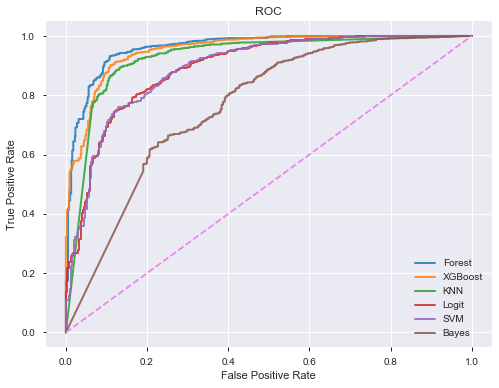

In [65]:
fit_dict = init_fit_dict.copy()

cur_X, cur_y = fix_data(tokamak_data)

plt.figure(figsize=(8,6))

print("ROC AUC score ")
labels = []
for cur_key in "for xgb dis log svm bay".split():
    cur_value = fit_dict[cur_key]
    if cur_key == "uni" : continue 
    fit, scaler, columns, indices = cur_value
    
    tmp_x = cur_X[cur_X.index.isin(indices)]
    tmp_y = cur_y[cur_y.index.isin(indices)]
    
    tmp_X = pd.DataFrame(scaler.transform(tmp_x[columns]),columns=columns)

    tmp_predict = fit.predict_proba(tmp_X)[:,1]
    fpr, tpr, thresholds = roc_curve(tmp_y, tmp_predict)

    labels.append(cur_key)
    plt.plot(fpr, tpr,lw=2, alpha=0.85)
    
    print(cur_key, "= ", round(roc_auc_score(tmp_y, tmp_predict),2))

for ii in range(len(labels)):
    labels[ii] = labels[ii].replace("for", "Forest")
    labels[ii] = labels[ii].replace("svm", "SVM")
    labels[ii] = labels[ii].replace("log", "Logit")
    labels[ii] = labels[ii].replace("dis", "KNN")
    labels[ii] = labels[ii].replace("xgb", "XGBoost")
    labels[ii] = labels[ii].replace("bay", "Bayes")
    
plt.plot([0,1],[0,1],c='violet',ls='--')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC")
plt.legend(labels);
    

In [114]:
fit_dict = init_fit_dict.copy()

del fit_dict["bay"]
del fit_dict["uni"]

def get_proba(is_jet):
    cur_X, cur_y = fix_data(tokamak_data)

    if is_jet:
        cur_y = cur_y[tokamak_data[tokamak_data.index.isin(cur_X.index)].tok == "JET"]
        cur_X = cur_X[tokamak_data[tokamak_data.index.isin(cur_X.index)].tok == "JET"]
    else:
        cur_y = cur_y[tokamak_data[tokamak_data.index.isin(cur_X.index)].tok != "JET"]
        cur_X = cur_X[tokamak_data[tokamak_data.index.isin(cur_X.index)].tok != "JET"]

    proba_matrix = np.zeros((len(fit_dict),len(cur_X),2))

    for cur_index, (cur_key, cur_value) in enumerate(fit_dict.items()):
        fit, scaler, columns, indices = cur_value

        tmp_X = pd.DataFrame(scaler.transform(cur_X[columns]),columns=columns)
        proba_matrix[cur_index,:,:] = fit.predict_proba(tmp_X)

    average_proba = np.zeros(proba_matrix.shape[1:])

    for i in range(len(cur_X)):
        for j in range(2):
            average_proba[i,j] = np.mean(proba_matrix[:,i,j])

    return cur_X, cur_y, average_proba


In [115]:
jet_x, jet_y, jet_proba = get_proba(True)
else_x, else_y, else_proba = get_proba(False)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [106]:
def make_confusion_matrix(threshold, tok):
    plt.figure(figsize=(11,5))
    threshold = float(threshold)
    
    plot_all = tok == "all"
    plot_jet = tok in ["all", "jet"]
    plot_else = tok in ["all", "else"]
    
    # jet
    if plot_jet:
        if plot_all: plt.subplot(1,2,1)
        y_expected = jet_y
        y_predict = jet_proba[:, 1] >= threshold

        fusion_confusion = confusion_matrix(y_expected, y_predict, labels=[1,0])

        ax = sns.heatmap(fusion_confusion, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=["P","N"], cbar=False, fmt='g')
        bottom, top = ax.get_ylim()
        plt.yticks([bottom,top], ["N","P"], rotation='horizontal')
        ax.set_ylim(bottom + .5, top - .5)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('JET (#)')
    
    # else
    if plot_else:
        if plot_all: plt.subplot(1,2,2)
        y_expected = else_y
        y_predict = else_proba[:, 1] >= threshold

        fusion_confusion = confusion_matrix(y_expected, y_predict, labels=[1,0])
        fusion_confusion = fusion_confusion / np.sum(fusion_confusion)

        for ii in range(2):
            for jj in range(2):
                fusion_confusion[ii,jj] = round(fusion_confusion[ii,jj],2)

        ax = sns.heatmap(fusion_confusion, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=["P","N"], cbar=False, fmt='g')
        bottom, top = ax.get_ylim()
        plt.yticks([bottom,top], ["N","P"], rotation='horizontal')
        ax.set_ylim(bottom + .5, top - .5)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Else (%)')
        
        if plot_all: 
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()

In [107]:
interact(make_confusion_matrix, threshold="0.432", tok=["all","jet","else"])

interactive(children=(Text(value='0.432', description='threshold'), Dropdown(description='tok', options=('all'…

<function __main__.make_confusion_matrix(threshold, tok)>

In [83]:
def forest_plot(ax, name, plot_title):
    plt.sca(ax)
    
    cur_clf, _, features, _ = fit_dict[name]
    importances = cur_clf.feature_importances_
    indices = reversed(np.argsort(importances))

    count = 0
    new_indices = []
    names = []
    for index in indices:
        if len(new_indices) >= 12 : break

        name = features[index]
        if name.startswith("_") : 
            new_indices.append(index)
            name = name.replace("abs_", "")[1:]
            names.append(name)
            continue
        name = name.replace("inv_", "")
        name = name.replace("log_", "")

        if name in names : continue
        names.append(name)

        new_indices.append(index)

    indices = list(reversed(new_indices))
    names = reversed(names)

    plt.title(plot_title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), names)
    plt.xlabel('')


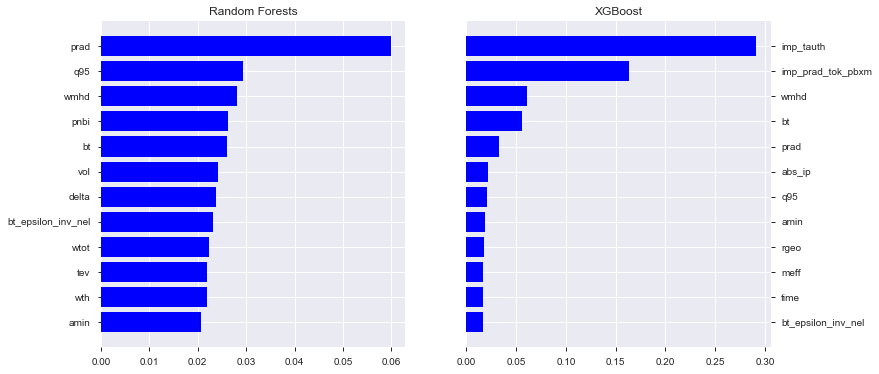

In [85]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
forest_plot(ax, "for", "Random Forests")
ax = plt.subplot(1,2,2)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
forest_plot(ax, "xgb", "XGBoost")

In [136]:
y_expected = jet_y
y_predict = jet_proba[:, 1] >= 0.432

count = 0

bad_indices = []

for index, (yy_expected, yy_predict) in enumerate(zip(y_expected, y_predict)):
    if yy_expected == yy_predict : continue
    if yy_expected == False : continue
    count += 1
    
    assert jet_y.iloc[index] == yy_expected
    assert jet_y.iloc[index] != yy_predict
    
    bad_indices.append(jet_x.index[index])
    
count


34

In [139]:
count = 0

is_bad = []
for ii in tokamak_data.index:
    if ii not in bad_indices: 
        is_bad.append(False)
    else:
        is_bad.append(True)
        
tokamak_data["is_bad"] = is_bad

In [213]:
all_data = tokamak_data[tokamak_data.tok == "JET"]
bad_data = all_data[all_data.is_bad]
jet_data = all_data[all_data.is_good]

used_cols = []
for tmp_col in all_data.columns:
    if len(all_data[tmp_col].unique()) < 5 : continue
    used_cols.append(tmp_col)

In [221]:
def scatter_data(xvar, yvar):
    plt.figure(figsize=(8,5))
    jet_xx = jet_data[xvar].copy()
    jet_yy = jet_data[yvar].copy()
    
    bad_xx = bad_data[xvar].copy()
    bad_yy = bad_data[yvar].copy()
    
    jet_xx -= np.min(all_data[xvar])
    bad_xx -= np.min(all_data[xvar])
    
    jet_yy -= np.min(all_data[yvar])
    bad_yy -= np.min(all_data[yvar])
    
    jet_xx /= np.max(all_data[xvar]) - np.min(all_data[xvar])
    bad_xx /= np.max(all_data[xvar]) - np.min(all_data[xvar])
    
    jet_yy /= np.max(all_data[yvar]) - np.min(all_data[yvar])
    bad_yy /= np.max(all_data[yvar]) - np.min(all_data[yvar])
    
    plt.scatter(jet_xx, jet_yy, alpha=0.025)
    plt.scatter(bad_xx, bad_yy, alpha=0.9)
    
    plt.xlabel(xvar)
    plt.title(yvar)
    

Text(0.5, 0, 'Beta')

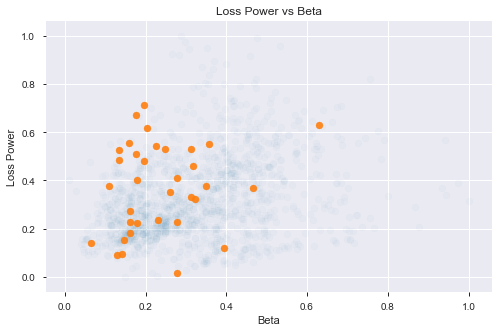

In [224]:
scatter_data("betmhd", "pl")
plt.title("Loss Power vs Beta")
plt.ylabel("Loss Power")
plt.xlabel("Beta")
# plt.legend(["Good", "Bad"]);

In [225]:
interact(
    scatter_data,
    xvar=widgets.Select(options=sorted(used_cols)),
    yvar=widgets.Select(options=list(reversed(sorted(used_cols))))
)

interactive(children=(Select(description='xvar', options=('_abs_bt_epsilon_inv_nel', '_abs_bt_inv_abs_ip_rgeo'…

<function __main__.scatter_data(xvar, yvar)>